<a href="https://colab.research.google.com/github/seafella/project_pensacola/blob/main/bathymetry_pensacola_deeper_csv_to_dem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio
!pip install ubelt

!gdalinfo --version

# test change

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 206 kB 4.4 MB/s 
GDAL 2.2.3, released 2017/11/20


In [ ]:
import glob
import os
import pandas as pd
import ubelt as ub


def process_deeper_file(file_in):
  df = pd.read_csv(file_in)
  file_out = file_in + '.tif'


  # the csv files exported from the app 
  # - have column headings
  # - include temp
  # - have null values for missing lat/long
  # the csv files exported from the website
  # - do not have column headings
  # - do not include temp
  # - have 0.0 values for missing lat/long


  try:
    # process app file
    df.drop(df.columns[[3,4]], axis=1, inplace=True)
    df= df.dropna(subset=['latitude'])
    df= df.dropna(subset=['longtitude']) # SIC
    df.columns = ['y', 'x', 'z']
  except IndexError as ie:
    # process website file
    df.drop(df.columns[[3]], axis=1, inplace=True)
    df.columns = ['y', 'x', 'z']
    df = df[df.x != 0.0]
    df = df[df.y != 0.0]



  # new_header = ['x', 'y', 'z', 'temp', 'timestamp'] 
  # new_header = ['y', 'x', 'z']
  # df.to_csv('tmp.csv', header=new_header)
  df.to_csv('tmp.csv')


  # df.to_csv('/path/to/file.csv')

  # I was unable to get the command to work with the CSV file alone
      # I needed to create a VRT that pointed at the CVS file.
  with open('tmp.vrt', 'w') as file:
      file.write(ub.codeblock(
          '''
          <OGRVRTDataSource>
              <OGRVRTLayer name="tmp">
                  <SrcDataSource>tmp.csv</SrcDataSource>
                  <SrcLayer>tmp</SrcLayer>
                  <LayerSRS>EPSG:4326</LayerSRS>
                  <GeometryType>wkbPoint</GeometryType>
                  <GeometryField encoding="PointFromColumns" x="x" y="y" z="d"/>
              </OGRVRTLayer>
          </OGRVRTDataSource>
          '''))

  # Can modify these but they are not needed
  # minx, miny = xyz.T[0:2].min(axis=1)
  # maxx, maxy = xyz.T[0:2].max(axis=1)
  # lonext = maxx - minx
  # latext = maxy - miny
  # ar = latext / lonext
  # xres = int(512)
  # yres = int(xres * ar)

  # Call the GDAL Grid command
  command = (
      'gdal_grid '
      '-ot Float32 -of GTiff '
      # '-zfield d '
      '-zfield z '
      '-a_srs EPSG:4326 '
      # f'-txe {minx - 1} {maxy + 1} '
      # f'-tye {miny - 1} {maxx + 1} '
      # f'-outsize {xres} {yres} '
      '-a invdist:power=2.0:smoothing=1.0 '
      '-a nearest:radius1=1.0:radius2=1.0 '
      '-a linear:radius=1.0 '
      f'tmp.vrt {file_out}')

  # ub.delete('tmp.csv')
  print(command)
  info = ub.cmd(command, verbose=3)
  assert info['ret'] == 0
  return file_out

/content/bathymetry_data-14.csv
gdal_grid -ot Float32 -of GTiff -zfield z -a_srs EPSG:4326 -a invdist:power=2.0:smoothing=1.0 -a nearest:radius1=1.0:radius2=1.0 -a linear:radius=1.0 tmp.vrt /content/bathymetry_data-14.csv.tif
┌─── START CMD ───
[ubelt.cmd] root@f87eae6f24b7:/content$ gdal_grid -ot Float32 -of GTiff -zfield z -a_srs EPSG:4326 -a invdist:power=2.0:smoothing=1.0 -a nearest:radius1=1.0:radius2=1.0 -a linear:radius=1.0 tmp.vrt /content/bathymetry_data-14.csv.tif
Grid data type is "Float32"
Grid size = (256 256).
Corner coordinates = (-87.143845 30.336941)-(-87.143401 30.336629).
Grid cell size = (0.000002 0.000001).
Source point count = 577.
Algorithm name: "linear".
Options are "radius=1.000000:nodata=0.000000"

0...10...20...30...40...50...60...70...80...90...100 - done.
└─── END CMD ───
data.shape = (256, 256)
/content/bathymetry_data-13.csv
gdal_grid -ot Float32 -of GTiff -zfield z -a_srs EPSG:4326 -a invdist:power=2.0:smoothing=1.0 -a nearest:radius1=1.0:radius2=1.0 -a

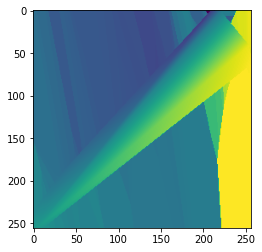

In [ ]:
#@title #change column names and remove rows without lat/long

# for file in glob.glob(r'/content/**/*.csv', recursive=True):    
for file in glob.glob(r'/content/*.csv', recursive=False):    
  print(file)
  out_file = process_deeper_file(file)
  if os.path.exists(out_file):
    # Show the result if it worked
    import tifffile
    data = tifffile.imread(out_file)
    from matplotlib import pyplot as plt
    print('data.shape = {!r}'.format(data.shape))
    plt.imshow(data)

In [ ]:
!gdaldem hillshade /content/out.tif output_hillshade.tif
!gdaldem slope /content/out.tif output_slope_map.tif
!gdaldem aspect /content/out.tif output_aspect_map.tif

# gdaldem color-relief input_dem color_text_file output_color_relief_map
#             [-alpha] [-exact_color_entry | -nearest_color_entry]
#             [-b Band (default=1)] [-of format] [-co "NAME=VALUE"]* [-q]
# where color_text_file contains lines of the format "elevation_value red green blue"

!gdaldem TRI /content/out.tif output_TRI_map.tif
!gdaldem TPI /content/out.tif output_TPI_map.tif
!gdaldem roughness /content/out.tif output_roughness_map.tif


ERROR 4: /content/out.tif: No such file or directory
GDALOpen failed - 4
/content/out.tif: No such file or directory
ERROR 4: /content/out.tif: No such file or directory
GDALOpen failed - 4
/content/out.tif: No such file or directory
ERROR 4: /content/out.tif: No such file or directory
GDALOpen failed - 4
/content/out.tif: No such file or directory
ERROR 4: /content/out.tif: No such file or directory
GDALOpen failed - 4
/content/out.tif: No such file or directory
ERROR 4: /content/out.tif: No such file or directory
GDALOpen failed - 4
/content/out.tif: No such file or directory
ERROR 4: /content/out.tif: No such file or directory
GDALOpen failed - 4
/content/out.tif: No such file or directory


In [ ]:
# !gdal_translate /content/2.csv /content/scan_data_20221203133307.tif
# ERROR 1: Ungridded dataset: At line 3, too many stepY values

ERROR 1: Ungridded dataset: At line 3, too many stepY values


In [ ]:
#@title this doesn't work
# Fast way to Convert .xyz elevation models to GeoTiff
# https://gist.github.com/philippkraft/2da0ab4314dd334463fe0e04985bba32


"""
Convert .xyz elevation models to GeoTiff
========================================

This gist, using highly optimized Python library Pandas does the conversion on the same computer in less then 1 second. 
The script parallizes the conversion of multiple files and translates 150 files á 1M lines in 17 seconds on 
16 core machine and a fast SSD. gdal_translate took 50 min.


Prerequisites:
--------------

$ pip install numpy pandas rasterio

Usage:
------

$ python3 xyz2tif.py *.xyz

To merge the resulting files into one raster

$ python3 xyz2tif.py merge *.tif
"""
import sys
import os
import multiprocessing
import time
import pandas as pd
import numpy as np
import rasterio as rio
from rasterio import transform as riotrans

CRS='EPSG:25832'

def load_xyz(fn: str) -> pd.DataFrame:
    """
    Loads a xyz data table from disk
    
    Parameters
    ----------
    fn : str
        File name
    """
    return pd.read_table(fn, names='x y z'.split(), sep=' ')
    # return pd.read_table(fn, names='x y z'.split(), sep=' ')

def xyz2matrix(xyz: pd.DataFrame) -> (np.ndarray, float, float, float, float):
    """
    Converts the xyz dataframe to a 2d numpy array with origin and bounding box
    """
    # print(xyz)
    print('here1')
    # mat = xyz.pivot_table(index='y', columns='x', values='z')
    mat = xyz.pivot_table(index='z', columns='y', values='x')
    print('here2')
    # print(mat)
    mat.sort_index(axis='index', ascending=False, inplace=True)
    mat.sort_index(axis='columns', ascending=True, inplace=True)
    print('here3')
    # Get origin (upper left corner)
    print(mat.columns[1])
    print(mat.columns[0])
    cellsize = mat.columns[1] - mat.columns[0]
    south = mat.index.min() - cellsize / 2
    north = mat.index.max() + cellsize / 2
    west = mat.columns.min() - cellsize / 2
    east = mat.columns.max() + cellsize / 2
       
    arr = np.asarray(mat, dtype=np.float32)
    
    return arr, west, south, east, north

def merge(outfile, *in_files):
    """
    Merges in_files (*.tif) to outfile
    """
    from rasterio.merge import merge as rmerge
    t0 = time.time()
    rasters = [rio.open(fn) for fn in in_files]
    t1 = time.time() -t0
    print(f'{t1:0.1f}s : Merging {len(rasters)} rasters')
    arr, transform = rmerge(rasters)
    t2 = time.time() - t0
    print(f'{t2:0.1f}s : Save {arr.shape[1]} x {arr.shape[2]} raster to {outfile}')
    with rio.open(
        outfile, 'w', 
        driver='GTiff',
        height= arr.shape[1], width = arr.shape[2],
        count=arr.shape[0], dtype=str(arr.dtype),
        crs=CRS, transform=transform, 
        compress='lzw', num_threads=os.cpu_count()
    ) as raster:
        raster.write(arr)
    t3 = time.time() - t0
    print(f'{t3:0.1f}s : Done')
    

def matrix2raster(fn_out:str, arr: np.ndarray, west: float, south: float, east: float, north: float):

    transform = riotrans.from_bounds(
        west=west, south=south,
        east=east, north=north,
        width=arr.shape[1],
        height=arr.shape[0]
    )
    
    with rio.open(
        fn_out, 'w', 
        driver='GTiff',
        height= arr.shape[0], width = arr.shape[1],
        count=1, dtype=str(arr.dtype),
        crs=CRS, transform=transform, compress='lzw'
    ) as raster:
        raster.write(arr, 1)
        
def process(fn_in, fn_out=None):
    xyz = load_xyz(fn_in)
    print(xyz2matrix(xyz))
    # arr, origin_y, origin_x, cellsize_y, cellsize_x = xyz2matrix(xyz)
    # fn_out = fn_out or fn_in.rsplit('.', 1)[0] + '.tif'
    # matrix2raster(fn_out, arr, origin_y, origin_x, cellsize_y, cellsize_x)
    # return fn_out

# def multi_process(files, *, nproc=None):
#     nproc = nproc or os.cpu_count()
#     with multiprocessing.Pool(nproc) as pool:
#         total = len(files)
        
#         print(f'Running {total} files on {nproc} processes')
#         t0 = time.time()
#         for i, fn_out in enumerate(pool.imap_unordered(process, files)):
#             et = time.time() - t0
#             tt = et * total / (i + 1)
#             print(f'{i}/{total} : {fn_out} {et:0.1f}s/{tt:0.1f}s')
    

# if __name__ == '__main__':
#     if len(sys.argv) == 1:
#         sys.stderr.write('Usage for conversion:\n$ python xyz2tif.py *.xyz\nUsage for merging:\n$ python xyz2tif.py merge *.tif')
#     elif 'merge' in sys.argv:
#         sys.argv.remove('merge')
#         merge('all_merge.tif', *sys.argv[1:])
#     else:
#         multi_process(sys.argv[1:])
        
    

# process('/content/tmp.csv', '/content/method2.tif')
# xyz2matrix(load_xyz('/content/tmp.csv'))

In [ ]:
# resources:

# https://gis.stackexchange.com/questions/254330/python-gdal-grid-correct-use

# maybe:

# https://stackoverflow.com/questions/38960568/using-gdal-in-python-to-produce-tiff-files-from-csv-files